# Asynchronous batch Bayesian optimization

As shown in [Asynchronous Bayesian Optimization](asynchronous_greedy_multiprocessing.ipynb) tutorial, Trieste provides support for running observations asynchronously. In that tutorial we used a greedy batch acquisition function called Local Penalization, and requested one new point whenever an observation was received. We also used the Python multiprocessing module to run distributed observations in parallel.

Here, we demonstrate a slightly different way of doing asynchronous Bayesian optimization. First, we make use of a non-greedy batch acquisition function, known as Batch Monte Carlo Expected Improvement. Second, we wait for several workers to finish, and then launch a new batch of points. However, since our batch size is smaller than the number of workers available, this approach is a hybrid between completely asynchronous and completely synchronous batch optimization. Note that greed acquisition functions also support batch sizes. Third, we use [Ray](https://www.ray.io/) to hide away most of the complexity of managing distributed workloads. There is no hard dependency in Trieste on a particular tool for parallel processing, and other libraries, such as [Dask](https://dask.org/), can be used.

Together these two notebooks give a comprehensive overview of how to use Trieste in asynchronous scenarios.

In [1]:
# silence TF warnings and info messages, only print errors
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.get_logger().setLevel("ERROR")
import ray
import numpy as np
import time

Just as in the other [notebook on asynchronous optimization](asynchronous_greedy_multiprocessing.ipynb), we use Branin function with delays.

In [2]:
from trieste.objectives import scaled_branin


def objective(points, sleep=True):
    if points.shape[1] != 2:
        raise ValueError(
            f"Incorrect input shape, expected (*, 2), got {points.shape}"
        )

    observations = []
    for point in points:
        observation = scaled_branin(point).numpy()
        if sleep:
            # insert some artificial delay that
            # increases linearly with the absolute value of points
            # which means our evaluations will take different time
            delay = 3 * np.sum(point)
            time.sleep(delay)
        observations.append((point, observation))

    return observations

In [3]:
# Let's confirm our objective function works as expected
objective(np.array([[0.1, 0.5]]), sleep=False)

[(array([0.1, 0.5]), array([-0.42052567]))]

To turn our objective function into a Ray task, we wrap it in a function with appropriate decorator. We are not using anything beyond Ray tasks API in this tutorial, and refer interested readers to [Ray documentation](https://docs.ray.io/en/latest/walkthrough.html) and [Ray crash course](https://github.com/anyscale/academy/blob/main/ray-crash-course/01-Ray-Tasks.ipynb) for more details.

In [4]:
@ray.remote
def ray_objective(points, sleep=True):
    return objective(points, sleep)

We prepare the model and some initial data to kick-start the optimization process.

In [5]:
from trieste.space import Box
from trieste.data import Dataset

search_space = Box([0, 0], [1, 1])
num_initial_points = 3
initial_query_points = search_space.sample(num_initial_points)
initial_observations = objective(initial_query_points, sleep=False)
initial_data = Dataset(
    query_points=initial_query_points,
    observations=tf.constant(
        [x[1] for x in initial_observations], dtype=tf.float64
    ),
)

import gpflow
from trieste.models.gpflow import GaussianProcessRegression, build_gpr


# We set the likelihood variance to a small number because
# we are dealing with a noise-free problem.
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)

Here we set up the configuration of our optimization run. See comments below for details.

In [6]:
# Number of worker processes to run simultaneously
# Setting this to 1 will reduce our optimization to non-batch sequential
num_workers = 6
# Number of observations to collect
num_observations = 30
# Batch size of the acquisition function. We will wait for that many workers to return before launching a new batch
batch_size = 2
# Set this flag to False to disable sleep delays in case you want the notebook to execute quickly
enable_sleep_delays = True

Now we are ready to define the optimizer. Notice how we set the acquisition function to be `BatchMonteCarloExpectedImprovement`. It is also the default function used by the `AsynchronousOptimization` rule, but here we specify it explicitly for clarity. We also set the batch size.

In [7]:
from trieste.acquisition.rule import AsynchronousOptimization
from trieste.acquisition.function import BatchMonteCarloExpectedImprovement
from trieste.ask_tell_optimization import AskTellOptimizer

monte_carlo_sample_size = 10000
acquisition_function = BatchMonteCarloExpectedImprovement(
    sample_size=monte_carlo_sample_size
)
async_rule = AsynchronousOptimization(acquisition_function, num_query_points=batch_size)  # type: ignore
async_bo = AskTellOptimizer(search_space, initial_data, model, async_rule)

Initialize Ray. This line will output the dashboard URL, which you can open in a separate tab to watch workers doing observations.

In [8]:
ray.init(ignore_reinit_error=True)

2022-02-15 12:41:42,082	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.1.1.60',
 'raylet_ip_address': '10.1.1.60',
 'redis_address': '10.1.1.60:6379',
 'object_store_address': '/tmp/ray/session_2022-02-15_12-41-39_266369_3799/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-15_12-41-39_266369_3799/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-15_12-41-39_266369_3799',
 'metrics_export_port': 60484,
 'node_id': 'c8cfd45f6e1a1c8e7e085793137b5364ec7e4a90b4016a4eab38f871'}

Here is the main optimization loop. First we ask for several batches of points to make sure all allocated workers are busy. Then we keep waiting for the workers to complete their tasks. Whenever `batch_size` of tasks came back, we tell Trieste new observations and ask for another batch of points.

In [9]:
points_observed = 0
workers = []

# a helper function to launch a worker for a numpy array representing a single point
def launch_worker(x):
    worker = ray_objective.remote(np.atleast_2d(x), enable_sleep_delays)
    workers.append(worker)


# get first couple of batches of points and init all workers
for _ in range(int(num_workers / batch_size)):
    points = async_bo.ask().numpy()
    np.apply_along_axis(launch_worker, axis=1, arr=points)

finished_workers = []
while points_observed < num_observations:
    ready_workers, remaining_workers = ray.wait(workers, timeout=0)
    finished_workers += ready_workers
    workers = remaining_workers

    if len(finished_workers) < batch_size:
        continue

    # we saw enough results to ask for a new batch

    new_observations = [
        observation
        for worker in finished_workers
        for observation in ray.get(worker)
    ]

    # new_observations is a list of tuples (point, observation value)
    # here we turn it into a Dataset and tell it to Trieste
    points_observed += len(new_observations)
    new_data = Dataset(
        query_points=tf.constant(
            [x[0] for x in new_observations], dtype=tf.float64
        ),
        observations=tf.constant(
            [x[1] for x in new_observations], dtype=tf.float64
        ),
    )
    async_bo.tell(new_data)

    # get a new batch of points
    # and launch workers for each point in the batch
    points = async_bo.ask().numpy()
    np.apply_along_axis(launch_worker, axis=1, arr=points)
    finished_workers = []

Let's plot the objective function and the points the optimization procedure explored.

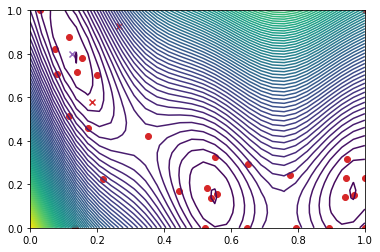

In [10]:
from util.plotting import plot_function_2d, plot_bo_points

dataset = async_bo.to_result().try_get_final_dataset()
arg_min_idx = tf.squeeze(tf.argmin(dataset.observations, axis=0))
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()
_, ax = plot_function_2d(
    scaled_branin,
    search_space.lower,
    search_space.upper,
    grid_density=30,
    contour=True,
)

plot_bo_points(
    query_points, ax[0, 0], num_initial_points, arg_min_idx, c_pass="tab:red"
)

In [11]:
ray.shutdown()  # "Undo ray.init()". Terminate all the processes started in this notebook.

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)